In [47]:
import numpy as np
import os
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter)
import cartopy.util as cutil
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import pearsonr

In [48]:
years = np.arange(1980, 2022, 1) # from 1980 to 2021 included
project_dir = '/Users/huripari/Documents/PhD/TCs_Genesis'
data_dir = os.path.join(project_dir, 'data')
tcg_maps_dir = os.path.join(data_dir, 'IBTrACS', '2.5x2.5', 'TCG')
climate_indices_dir = os.path.join(data_dir, 'CI')

In [49]:
# Load and compute total number of TCGs from 1980 to 2021
tcg_list = []
tcg_list_month = []
for y in years:
    file = os.path.join(tcg_maps_dir, 'TCG_2.5x2.5_{}.nc'.format(y))
    ds = xr.open_dataset(file)
    tcg_ts = ds.tcg.sum(dim=['latitude', 'longitude'])
    tcg = ds.tcg.sum(dim='time')
    tcg_list.append(tcg)
    tcg_list_month.append(tcg_ts)
tcg_year = xr.concat(tcg_list, dim='year')
tcg_tot = tcg_year.sum(dim='year')
tcg_month = xr.concat(tcg_list_month, dim='time')
# Load PDO index
filename = os.path.join(climate_indices_dir, 'PDO.txt')
date_range = pd.date_range(start=f'{1980}-01-01', end=f'{2021}-12-01', freq='MS')
df_pdo = pd.DataFrame(index=date_range, columns=['PDO'])
data = pd.read_table(filename, sep='\s+', header=None)
for r, row in enumerate(df_pdo.iterrows()):
    idx = df_pdo.index[r]
    month = idx.month
    year = idx.year
    df_pdo.loc[idx, 'PDO'] = data[(data[0] == year)][month].values[0]

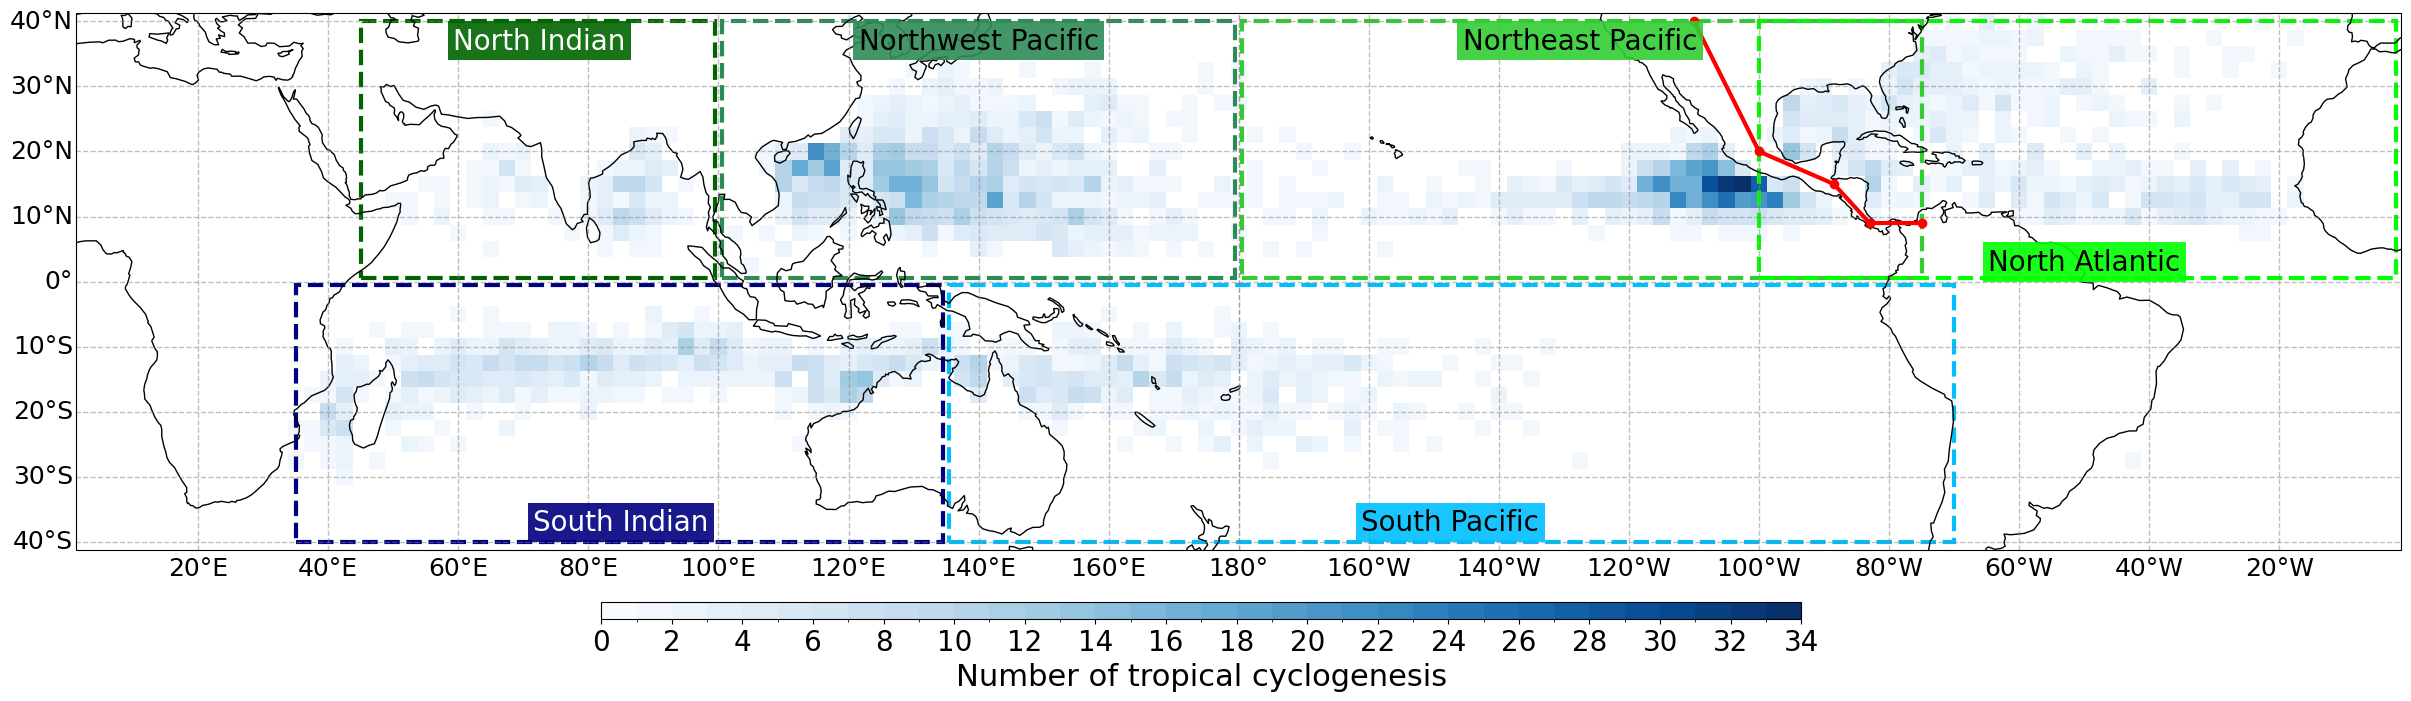

In [50]:
## Plot total number of tropical cyclones genesis from 1980 to 2021 ##
# Set the colorbar
vmax = tcg_tot.max().values
boundaries = np.arange(0, vmax+1, 1)
norm = mcolors.BoundaryNorm(boundaries, ncolors=len(boundaries)-1)
cmap = plt.get_cmap('Blues', len(boundaries)-1)
cmap.set_bad(alpha=0)
var_masked = np.ma.masked_where(tcg_tot.values == 0, tcg_tot.values)
# Make the data cyclic to avoid whit band at 360°E
var, clon, clat = cutil.add_cyclic(var_masked, tcg_tot.longitude.values, tcg_tot.latitude.values)
# Start figure and set coastlines
fig = plt.figure(figsize=(30, 8.5))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 0.05])
ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines()
# Set gridlines, ticks and labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()
gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 20))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 91, 10))
gl.xlabel_style = {'size': 18} 
gl.ylabel_style = {'size': 18}
# Plot the variable
field = ax.pcolormesh(clon, clat, var, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
# Add the colorbar
ax_cbar = fig.add_subplot(gs[1])
cbar = plt.colorbar(field, cax=ax_cbar, extend='neither', orientation='horizontal')
ax_cbar.set_position([0.3, 0.15, 0.4, 0.02]) # [left, bottom, width, height]
cbar.set_ticks(np.arange(0, vmax+1, 2))
cbar.ax.tick_params(labelsize=20)
cbar.set_label('Number of tropical cyclogenesis', size=22)
# Add boxes for the sub-basin definitions
# Define the sub-basins
bb=0.5
sub_basins = [
    {"name": "North Indian", "bounds": [45, 100-bb, 0+bb, 40], "text_pos": [72.5, 37], "color": 'darkgreen', "fontcolor": 'white'},
    {"name": "Northwest Pacific", "bounds": [100+bb, 180-bb, 0+bb, 40], "text_pos": [140, 37], "color": 'seagreen', "fontcolor": 'black'},
    {"name": "Northeast Pacific", "bounds": [-180+bb, -75, 0+bb, 40], "text_pos": [-127.5, 37], "color": 'limegreen', "fontcolor": 'black'},
    {"name": "North Atlantic", "bounds": [-100, -2, 0+bb, 40], "text_pos": [-50, 3], "color": 'lime', "fontcolor": 'black'},
    {"name": "South Pacific", "bounds": [135+bb, 290, -40, 0-bb], "text_pos": [212.5, -37], "color": 'deepskyblue', "fontcolor": 'black'},
    {"name": "South Indian", "bounds": [35, 135-bb, -40, 0-bb], "text_pos": [85, -37], "color": 'navy', "fontcolor": 'white'},
]
# Add the sub-basin boxes and labels
for basin in sub_basins:
    bounds = basin["bounds"]
    text_pos = basin["text_pos"]
    col = basin["color"]
    fontcol = basin["fontcolor"]
    rect = Rectangle((bounds[0], bounds[2]), bounds[1] - bounds[0], bounds[3] - bounds[2],
                     linewidth=3, edgecolor=col, linestyle='--', facecolor='none', 
                     transform=ccrs.PlateCarree())
    ax.add_patch(rect)
    ax.text(text_pos[0], text_pos[1], basin["name"],
            horizontalalignment='center', verticalalignment='center', transform=ccrs.PlateCarree(),
            bbox=dict(facecolor=col, alpha=0.9, edgecolor='none'), fontdict={'size': 20, 'color': fontcol})
# Add a line demarking split between Atlantic and Pacific basins for cyclogenesis
lons = [-110, -100, -88.5, -83, -75]
lats = [40, 20, 15, 9, 9]
ax.plot(lons, lats, color='red', linewidth=3, marker='o', transform=ccrs.PlateCarree())
# ax.set_title('Total number of tropical cyclones genesis from 1980 to 2021', size=26);
fig_path = os.path.join('figures', 'global_tcg_and_subbasins.pdf')
plt.savefig(fig_path, bbox_inches='tight', format='pdf', dpi=300)

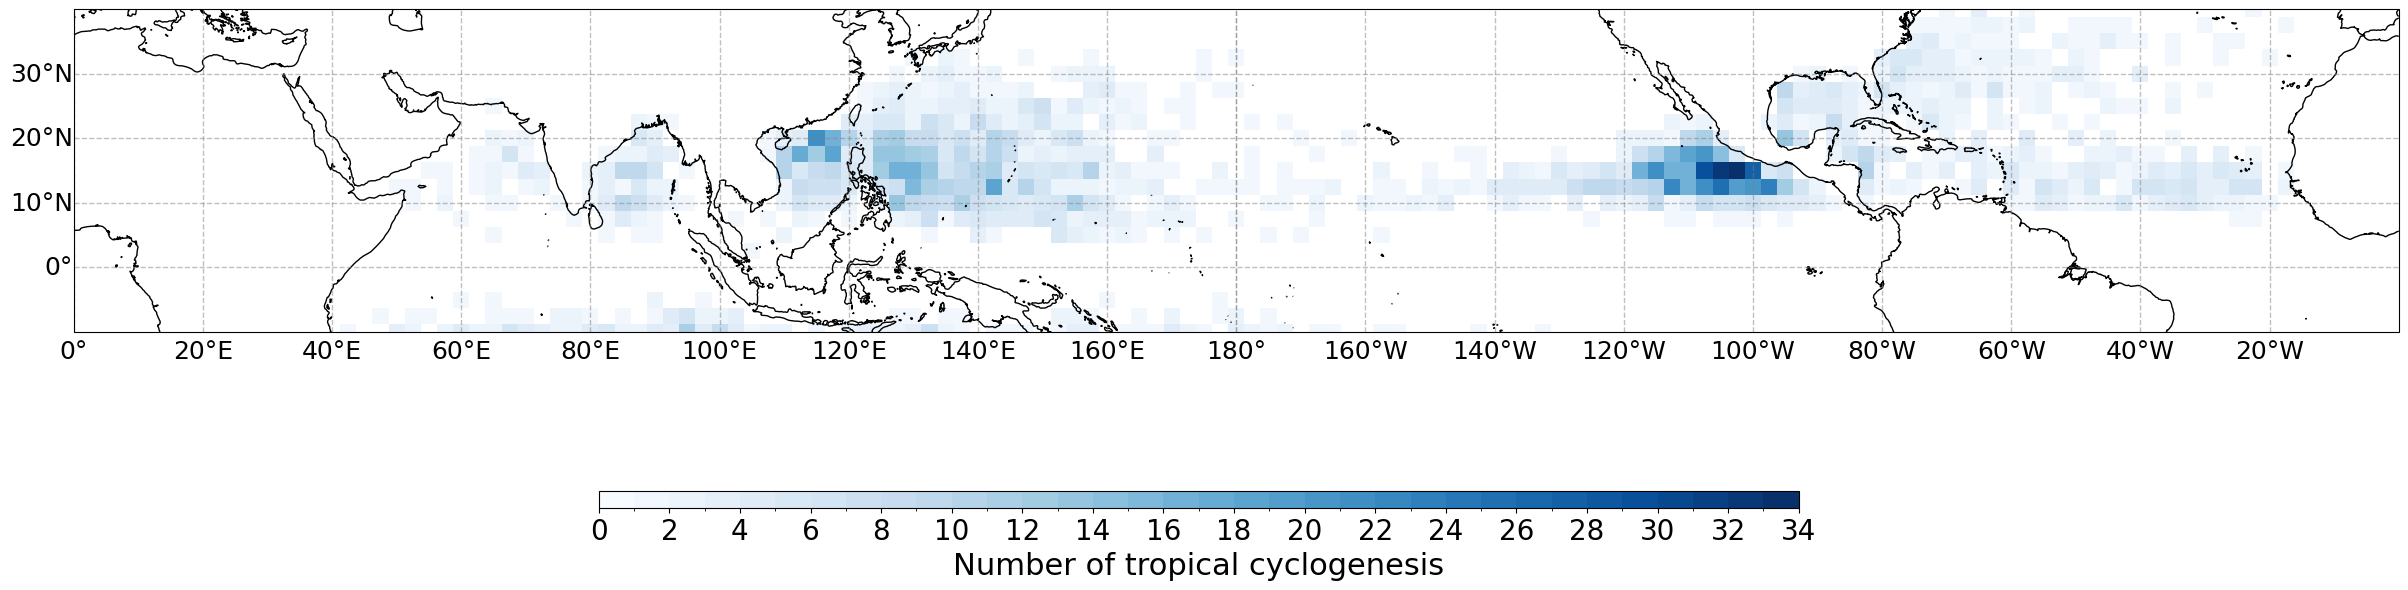

In [9]:
## Plot total number of tropical cyclones genesis from 1980 to 2021 ##
# Set the colorbar
vmax = tcg_tot.max().values
boundaries = np.arange(0, vmax+1, 1)
norm = mcolors.BoundaryNorm(boundaries, ncolors=len(boundaries)-1)
cmap = plt.get_cmap('Blues', len(boundaries)-1)
cmap.set_bad(alpha=0)
var_masked = np.ma.masked_where(tcg_tot.values == 0, tcg_tot.values)
# Make the data cyclic to avoid whit band at 360°E
var, clon, clat = cutil.add_cyclic(var_masked, tcg_tot.longitude.values, tcg_tot.latitude.values)
# Start figure and set coastlines
fig = plt.figure(figsize=(30, 8.5))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 0.05])
ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=180))
ax.set_extent([-110, 0, -10, 40], crs=ccrs.PlateCarree())
ax.coastlines()
# Set gridlines, ticks and labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()
gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 20))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 91, 10))
gl.xlabel_style = {'size': 18} 
gl.ylabel_style = {'size': 18}
# Plot the variable
field = ax.pcolormesh(clon, clat, var, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
# Add the colorbar
ax_cbar = fig.add_subplot(gs[1])
cbar = plt.colorbar(field, cax=ax_cbar, extend='neither', orientation='horizontal')
ax_cbar.set_position([0.3, 0.15, 0.4, 0.02]) # [left, bottom, width, height]
cbar.set_ticks(np.arange(0, vmax+1, 2))
cbar.ax.tick_params(labelsize=20)
cbar.set_label('Number of tropical cyclogenesis', size=22)

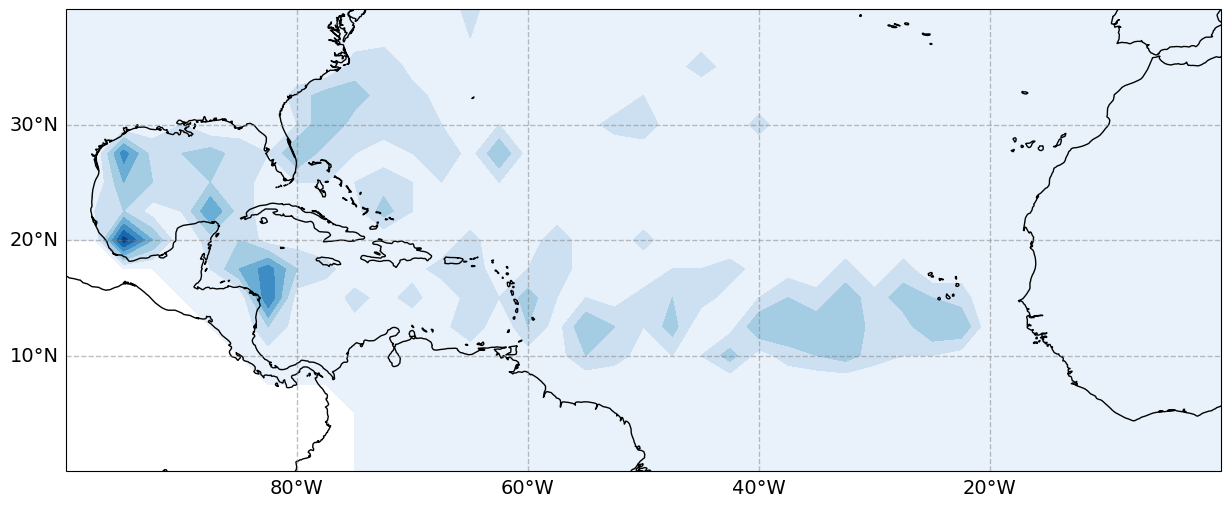

In [46]:
# Plot total number of tropical cyclones genesis from 1980 to 2020 in the North Atlantic
# Domain Boundaries [100°W, 0°E, 0°N, 40°N]
tcg_tot_cropped = tcg_tot.where((tcg_tot.longitude >= -100) & (tcg_tot.longitude <= 0) & (tcg_tot.latitude >= 0) & (tcg_tot.latitude <= 40), drop=True)
NA_mask = xr.open_dataarray(os.path.join(project_dir, 'tcg_fsM', 'data', 'NA_mask.nc'))
tcg_NA = tcg_tot_cropped.where(NA_mask == 1)

# Start figure and set coastlines
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
ax.coastlines()

# Set gridlines, ticks and labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()
gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 20))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 91, 10))
gl.xlabel_style = {'size': 14} 
gl.ylabel_style = {'size': 14}

# Plot the variable
field = ax.contourf(tcg_tot_cropped.longitude.values, tcg_tot_cropped.latitude.values, tcg_NA.values, transform=ccrs.PlateCarree(), cmap='Blues')
# cbar = plt.colorbar(field, orientation='horizontal', extend='neither', pad=0.01, aspect=8, shrink=2)
cbar.ax.tick_params(labelsize=14)

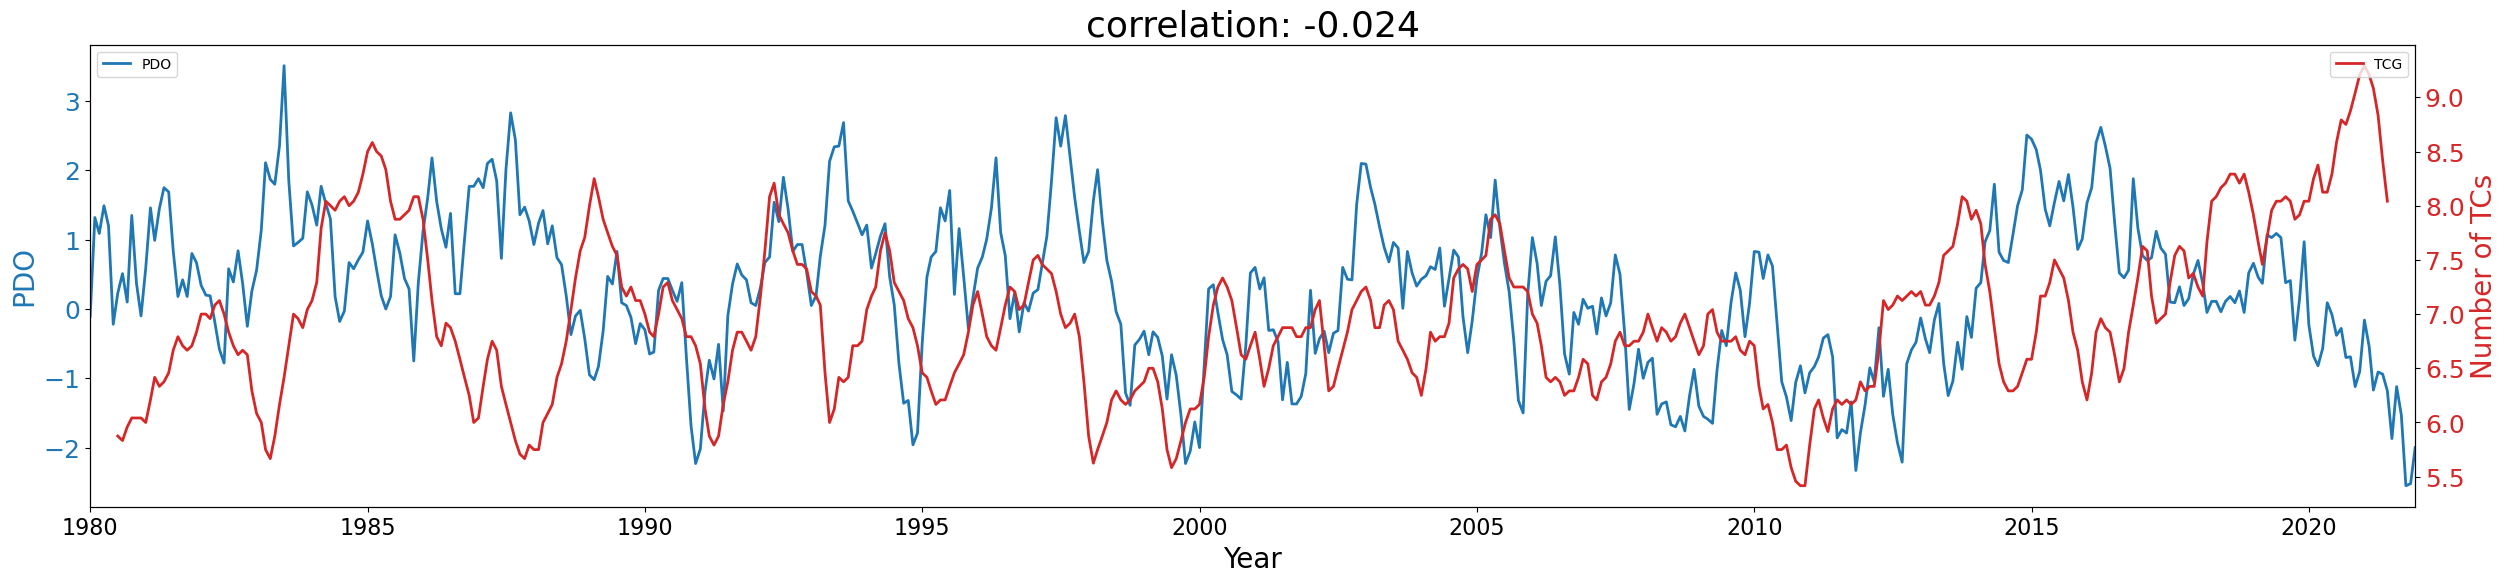

In [19]:
# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(30, 6))

decomposition = seasonal_decompose(tcg_month.to_dataframe(), model='additive')
trend = decomposition.trend

trend_isnan = ~np.isnan(trend.values)
r, _ = pearsonr(df_pdo.values.flatten()[trend_isnan], trend.values[trend_isnan].flatten())

# Plot the first time series (PDO index) on the primary y-axis
color1 = 'tab:blue'
ax1.set_xlabel('Year', size=20)
ax1.set_ylabel('PDO', color=color1, size=20)
ax1.plot(df_pdo.index, df_pdo.values, color=color1, linewidth=2, label="PDO")  # Ensure proper x-values
ax1.tick_params(axis='y', labelcolor=color1, labelsize=18)
ax1.set_title(f'correlation: {r:.3f}', size=26)

# Create a second y-axis for the second time series (TCG)
ax2 = ax1.twinx()  
color2 = 'tab:red'
ax2.set_ylabel('Number of TCs', color=color2, size=20)
ax2.plot(tcg_month.time, trend.values, color=color2, linewidth=2, label="TCG")  # Ensure proper x-values
ax2.tick_params(axis='y', labelcolor=color2, labelsize=18)

# Set x-axis format properly
ax1.tick_params(axis='x', labelsize=16)
ax1.set_xlim([df_pdo.index.min(), df_pdo.index.max()])  # Set x-axis limits to match dataset

# Show legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()

In [20]:
mpi_list = []
sst_list = []
for y in years:
    mpi_file = os.path.join(data_dir, 'ERA5dv', '2.5x2.5', 'MPI', 'MPI_2.5x2.5_{}.nc'.format(y))
    sst_file = os.path.join(data_dir, 'ERA5', '2.5x2.5', 'MSLP-SST', 'ERA5_MSLP-SST_2.5x2.5_{}.nc'.format(y))
    ds = xr.open_dataset(mpi_file).mpi
    mpi_list.append(ds)
    ds = xr.open_dataset(sst_file).sst
    sst_list.append(ds)
mpi_ds = xr.concat(mpi_list, dim='time')
sst_ds = xr.concat(sst_list, dim='time')

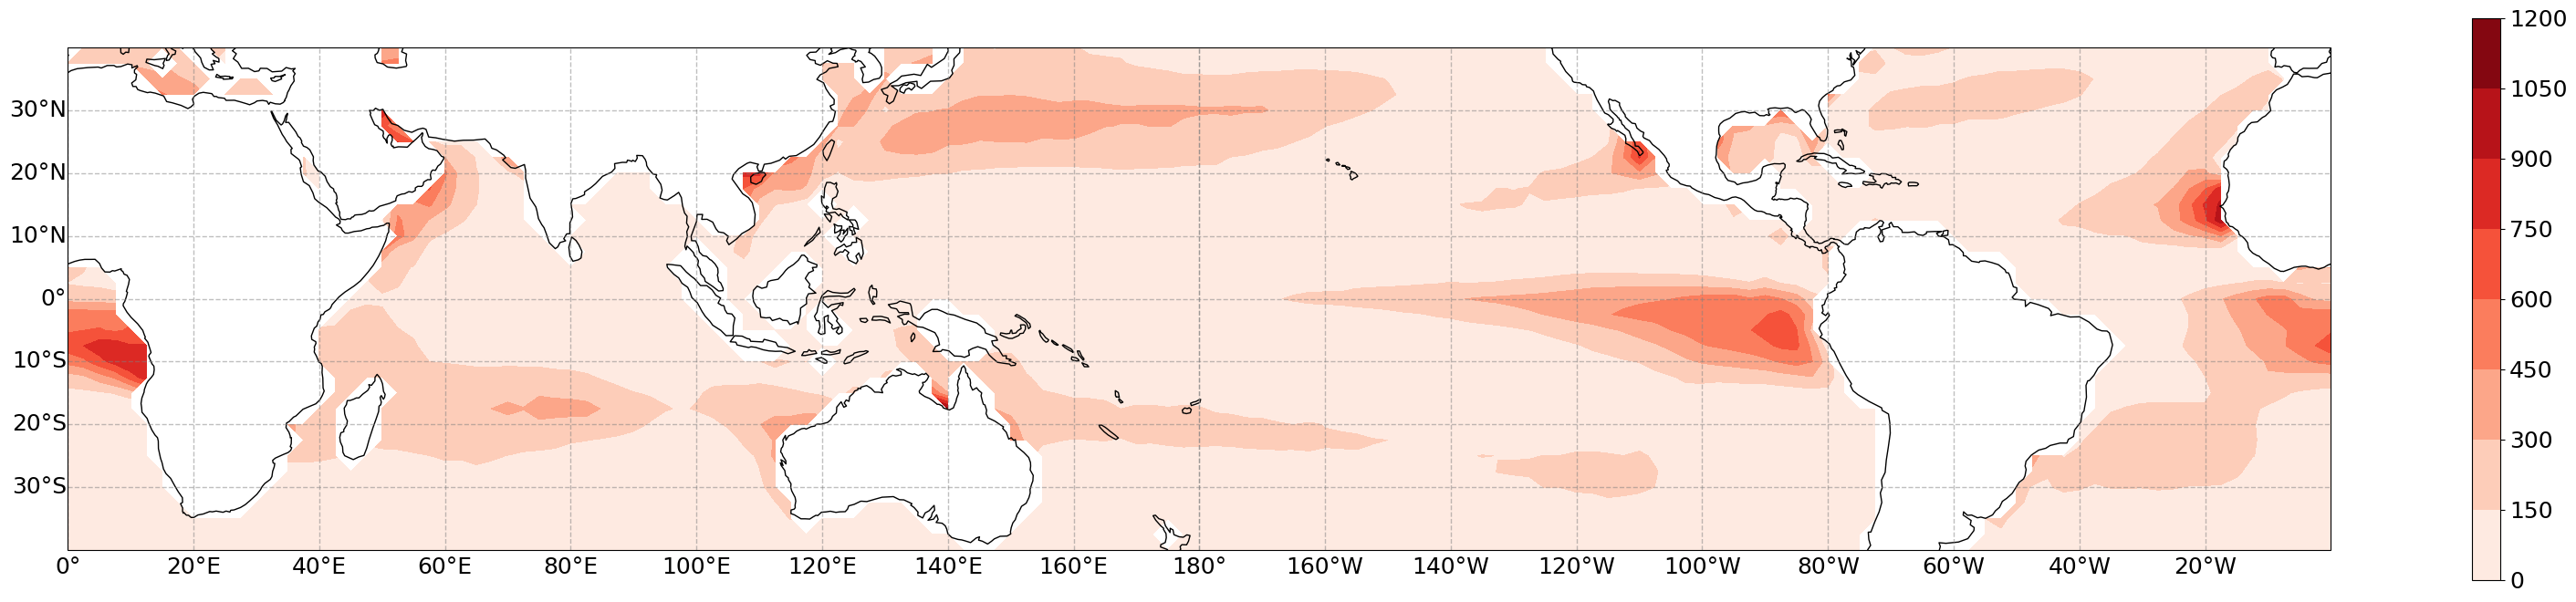

In [21]:
## Variance of MPI ## 
mpi_var = mpi_ds.var(dim='time')
# Make the data cyclic to avoid whit band at 360°E
var, clon, clat = cutil.add_cyclic(mpi_var.values, mpi_var.longitude.values, mpi_var.latitude.values)
# Start figure and set coastlines
fig = plt.figure(figsize=(40, 8))
ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines()
# Set gridlines, ticks and labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()
gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 20))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 91, 10))
gl.xlabel_style = {'size': 18} 
gl.ylabel_style = {'size': 18}
# Plot the variable
field = ax.contourf(clon, clat, var, transform=ccrs.PlateCarree(), cmap='Reds')
cbar = plt.colorbar(field)
cbar.ax.tick_params(labelsize=18)

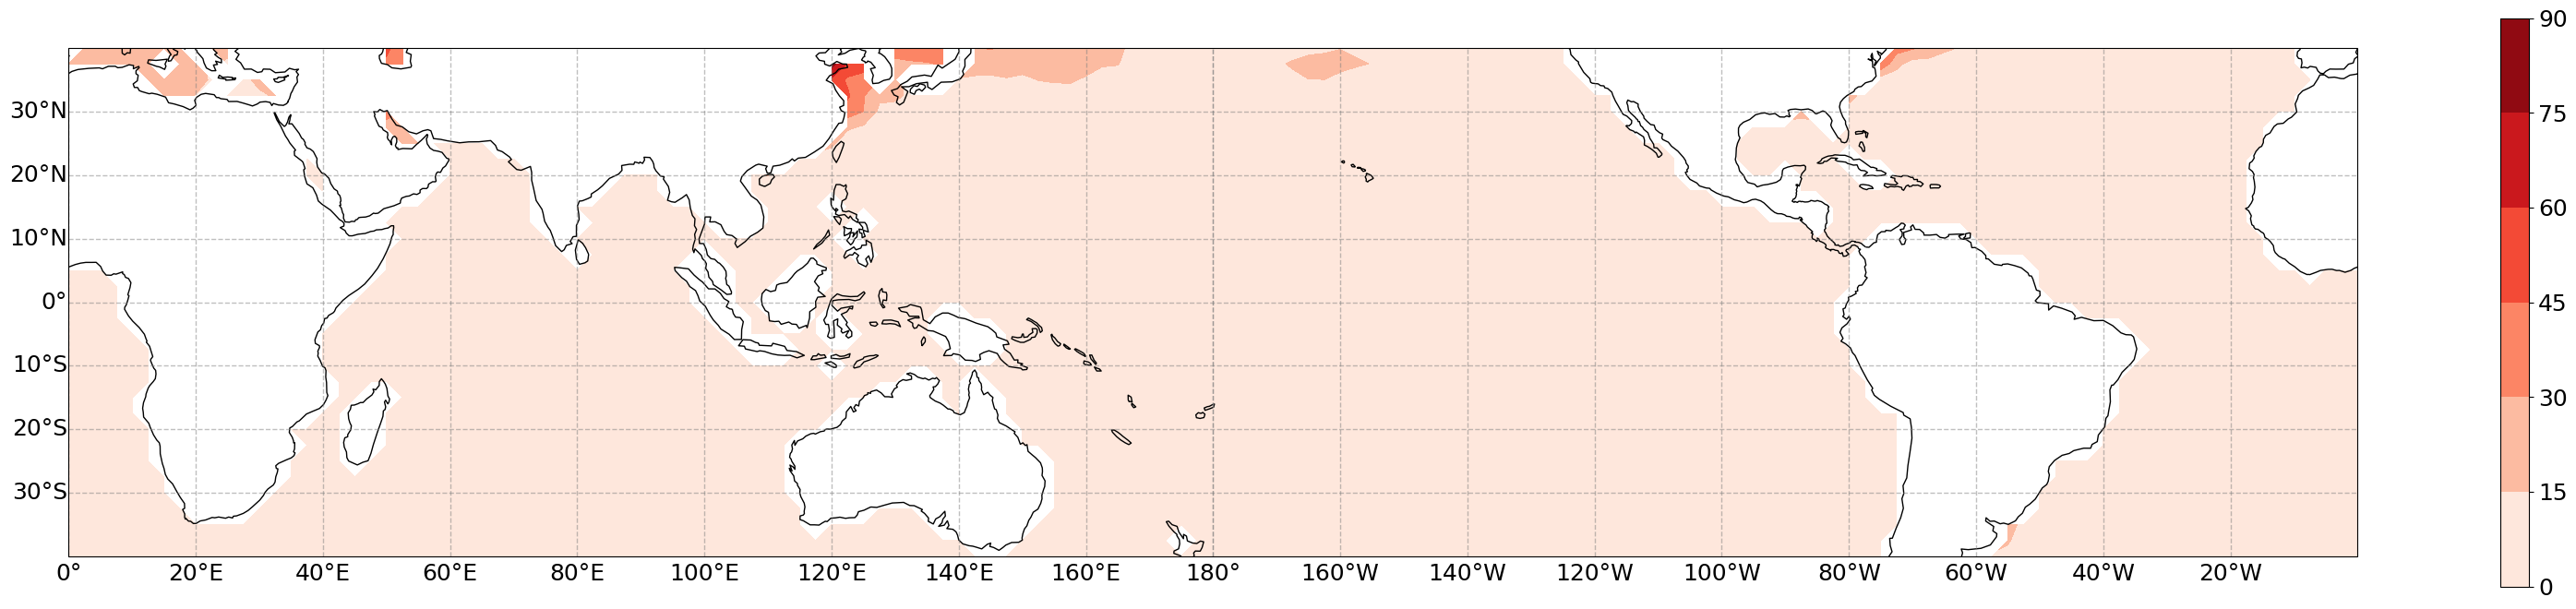

In [22]:
## Variance of SST ## 
sst_var = sst_ds.var(dim='time')
# Make the data cyclic to avoid whit band at 360°E
var, clon, clat = cutil.add_cyclic(sst_var.values, sst_var.longitude.values, sst_var.latitude.values)
# Start figure and set coastlines
fig = plt.figure(figsize=(40, 8))
ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines()
# Set gridlines, ticks and labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()
gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 20))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 91, 10))
gl.xlabel_style = {'size': 18} 
gl.ylabel_style = {'size': 18}
# Plot the variable
field = ax.contourf(clon, clat, var, transform=ccrs.PlateCarree(), cmap='Reds')
cbar = plt.colorbar(field)
cbar.ax.tick_params(labelsize=18)